In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

Подключим диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ДЗ_деревья/2 дз/amazon_co-ecommerce_sample.csv'
with open(path, 'r') as f:
  source_df = pd.read_csv(f).drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])
df = source_df.copy()
df

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
...,...,...,...,...,...,...,...
9995,Mattel,£22.95,5 new,3,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...
9996,Star Wars,£39.99,NaN,1,3.0,4.0 out of 5 stars,Characters & Brands > Star Wars > Toys
9997,Olde Scotland Yard Ltd.,£43.99,3 new,1,3.0,5.0 out of 5 stars,Novelty & Special Use > Novelty > Accessories ...
9998,DC Comics,£49.81,3 new,1,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...


## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [ ]:
df.isnull().sum() #проверим количество пустых данных по всем колонкам

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64

In [ ]:
(df.shape[0] - df.count())/df.shape[0] #найдём отношение количества пустых значений к общему количеству данных в столбцах

manufacturer                        0.0007
price                               0.1435
number_available_in_stock           0.2500
number_of_reviews                   0.0018
number_of_answered_questions        0.0765
average_review_rating               0.0018
amazon_category_and_sub_category    0.0690
dtype: float64

In [ ]:
#df = df.drop(columns = ['number_available_in_stock']) #выбросим на четверть пустой ненужный столбец данных

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [ ]:
prices = df['price'].str.replace('£|,','',regex=True)
df['price'] = prices.str.split(' - ', expand=True).astype(float).mean(axis=1) #будем брать среднее арифметическое для значений типо "£500 - £600"

df['number_available_in_stock'] =  df['number_available_in_stock'].str.split('\xa0', n=1, expand=True).iloc[:, 0].astype(float)

categories = df['amazon_category_and_sub_category'].str.split(' > ',expand=True) 
categories.columns = ['sub_category_' + str(i) for i in range(categories.shape[1])]
for i in range(categories.shape[1]):
  categories['sub_category_' + str(i)] = pd.factorize(categories['sub_category_' + str(i)])[0] + 1

df = df.drop('amazon_category_and_sub_category', axis=1)
df = pd.concat([df, categories], axis=1)
categories.head()

,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,0
3,1,1,1,1,0
4,1,1,1,1,0


In [ ]:
df['number_of_reviews'] = source_df['number_of_reviews'].str.replace(',','') #ValueError: could not convert string to float: '1,040'
df['number_of_reviews'] = df['number_of_reviews'].astype(float)

onehot_encode = pd.get_dummies(df['manufacturer'])
df = df.drop('manufacturer', axis = 1)
df = df.join(onehot_encode)
df['average_review_rating'] = df['average_review_rating'].str.split(' ', n=1, expand=True).iloc[:, 0].astype(float)


In [ ]:
df = df.dropna() #удалим неполные данные
df = df.reset_index()
df = df.drop(columns=['index'])
df

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4,...,ukgiftstoreonline,unbespielt,uni-ball,unisex party bag fillers,universal hobby,woooow doll,xs-party,yugioh,zizzi,|MFG
0,3.42,5.0,15.0,1.0,4.9,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9.99,2.0,17.0,2.0,3.9,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,69.93,3.0,36.0,7.0,4.3,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,235.58,4.0,1.0,1.0,5.0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,27.49,6.0,1.0,1.0,5.0,1,1,1,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5867,9.99,5.0,2.0,3.0,4.0,1,29,13,0,0,...,0,0,0,0,0,0,0,0,0,0
5868,22.95,5.0,3.0,3.0,5.0,1,29,13,0,0,...,0,0,0,0,0,0,0,0,0,0
5869,43.99,3.0,1.0,3.0,5.0,29,67,3,21,0,...,0,0,0,0,0,0,0,0,0,0
5870,49.81,3.0,1.0,3.0,5.0,1,29,13,0,0,...,0,0,0,0,0,0,0,0,0,0


Для наглядности сравним с исходной таблицей

In [ ]:
source_df

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
...,...,...,...,...,...,...,...
9995,Mattel,£22.95,5 new,3,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...
9996,Star Wars,£39.99,NaN,1,3.0,4.0 out of 5 stars,Characters & Brands > Star Wars > Toys
9997,Olde Scotland Yard Ltd.,£43.99,3 new,1,3.0,5.0 out of 5 stars,Novelty & Special Use > Novelty > Accessories ...
9998,DC Comics,£49.81,3 new,1,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...


# Обучение модели (3 балла)

In [ ]:
from sklearn.model_selection import train_test_split
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.45, random_state=43) # а вот возьму и не поставлю 42, что ты мне сделаешь??????

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor = dummy_regressor.fit(X_train, y_train)
y_pred = dummy_regressor.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, y_pred)
print(MSE)
print(RMSE)
r2

2817.7335370019505
53.082327916190245


-6.745040142797087e-05

## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor()
dt_regressor = dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

r2

-0.045763891036680215

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_regressor = LinearRegression()
lin_regressor = lin_regressor.fit(X_train, y_train)
y_pred = lin_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

r2

-5.918021042270295e+17

хрена с два мне, а не положительный $R^2$



# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

100%|██████████| 34/34 [00:12<00:00,  2.65it/s]


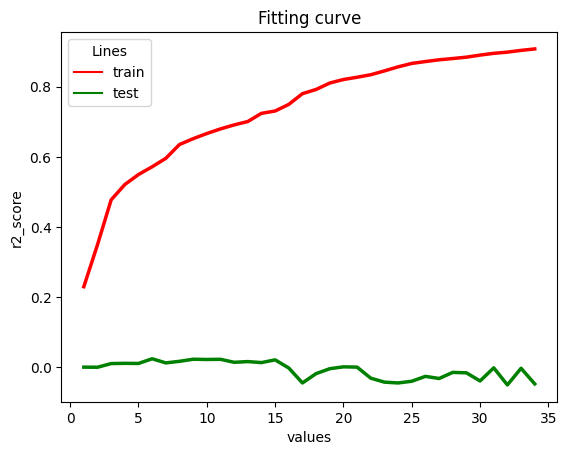

In [ ]:
import seaborn as sns
from tqdm import tqdm

def fit_curve_plot(
    model_ctor, mc_parameter: str, values: list, score, X_train, X_test, y_train, y_test
):
  train_curve = []
  test_curve = []
  for value in tqdm(values):
        model = model_ctor(**{mc_parameter: value}) 
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train))
        test_curve.append(score(y_test, y_pred_test))
  train_curve = pd.DataFrame(train_curve, index=values, columns=['r2_score'])
  test_curve = pd.DataFrame(test_curve, index=values, columns=['r2_score'])
  data_test = pd.concat([train_curve, test_curve], axis=0, keys=['train', 'test']).reset_index()
  data_test = data_test.rename(columns={'level_0': 'Lines', 'level_1': 'values'})
  sns.lineplot(data=data_test, x='values', y='r2_score', hue='Lines', palette=['r', 'g'], linewidth=2.5).set(title='Fitting curve')

fit_curve_plot(DecisionTreeRegressor, 'max_depth', np.arange(1, 35), r2_score, X_train, X_test, y_train, y_test)

Реально, хрен мне, а не положительный $R^2$

100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


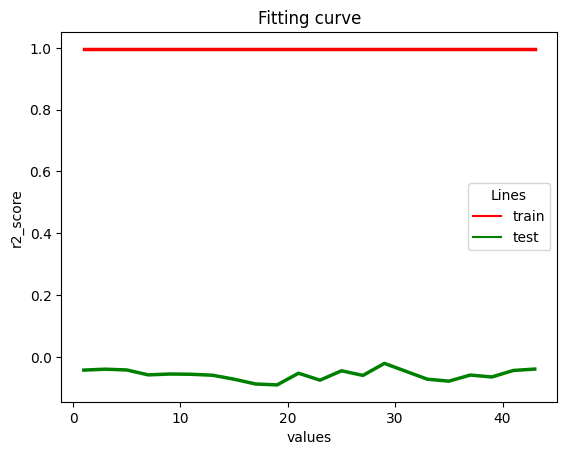

In [ ]:
fit_curve_plot(DecisionTreeRegressor, 'random_state', np.arange(1, 45, 2), r2_score, X_train, X_test, y_train, y_test) #чтобы мне поделать лишь бы не выбрать 42б хе-хе

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [ ]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        #  y = y.reset_index(drop=True) ХЗ ПАЧЕМУ, НО ОНО ВСё ЛОМАЛО
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=43) #никакого 42!!!
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию? 

Что-то он вообще не работает. Плак-плак(((((

```
KeyError                                  Traceback (most recent call last)
<ipython-input-105-fb3770aec7dd> in <cell line: 2>()
      1 ens_regressor = EnsembleTreeRegressor()
----> 2 ens_regressor = ens_regressor.fit(X_train, y_train)
      3 y_pred = ens_regressor.predict(X_test)
      4 r2 = r2_score(y_test, y_pred)
      5 r2

8 frames
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py in _raise_if_missing(self, key, indexer, axis_name)
   6131 
   6132             not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())
-> 6133             raise KeyError(f"{not_found} not in index")
   6134 
   6135     @overload

KeyError: '[5694, 8095, 3929, 9303, 5406, 4895, 4783, 8508, 7995, 6610, 8363, 8255, 9187, 3678, 3915, 9555, 5103, 9262, 8906, 5650, 4142, 7269, 4382, 5050, 5108, 4118, 5530, 9532, 5568, 7328, 7702, 5335, 9849, 7485, 6286, 3870, 6055, 6616, 7847, 7894, 8030, 4587, 4967, 6752, 6719, 9285, 7181, 5586, 8596, 7870, 7692, 8219, 4965, 7904, 4998, 5535, 8701, 4834, 6669, 6454, 4424, 4538, 7902, 9422, 8544, 9462, 6810, 9991, 6317, 7930, 5082, 9658, 7280, 6791, 5053, 7240, 4812, 6703, 6148, 6483, 6624, 8848, 8819, 5539, 7444, 4677, 6546, 3970, 9360, 5909, 9937, 8673, 5638, 6813, 4721, 7950, 4081, 9211, 9348, 4810, 5065, 5052, 8337, 9092, 5742, 6026, 9739, 4208, 5894, 7004, 5151, 7844, 7386, 7633, 7066, 5648, 3866, 7923, 5911, 4469, 4242, 5686, 5744, 3811, 4930, 5763, 4937, 3908, 9669, 4613, 8874, 4885, 5692, 5006, 6189, 7588, 5341, 9810, 7776, 5557, 7470, 6730, 6042, 8081, 9421, 4308, 7248, 8751, 5497, 4507, 6552, 9128, 4902, 6239, 4817, 9945, 5288, 4078, 9518, 6957, 4334, 5386, 6874, 9168, 5084, 9124, 5217, 7958, 9096, 5187, 4253, 7850, 7802, 8949, 7060, 7143, 8500, 6964, 4087, 7405, 5373, 9174, 4065, 5702, 6608, 8468, 7852, 6688, 3950, 9461, 7784, 9827, 3944, 8572, 6431, 8892, 4195, 6718, 9488, 5600, 4647, 5861, 8965, 6502, 6737, 7714, 5413, 7474, 6795, 5587, 8894, 5760, 6187, 6341, 8756, 6847, 8752, 6952, 7194, 3681, 7945, 5833, 9665, 8909, 6661, 5015, 5576, 4611, 8838, 5107, 9650, 9865, 7410, 7552, 3596, 4718, 7725, 3713, 5486, 6653, 7144, 6739, 8101, 4923, 3971, 6351...
```

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

А, не, починил


In [ ]:
ens_regressor = EnsembleTreeRegressor()
ens_regressor = ens_regressor.fit(X_train, y_train)
y_pred = ens_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

r2

-0.04854705406067761

100%|██████████| 14/14 [00:58<00:00,  4.21s/it]


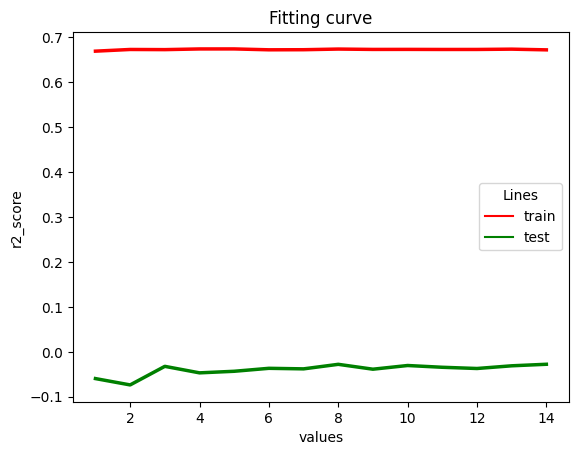

In [ ]:
fit_curve_plot(EnsembleTreeRegressor, 'num_trees', np.arange(1, 15), r2_score, X_train, X_test, y_train, y_test) 

100%|██████████| 9/9 [00:24<00:00,  2.68s/it]


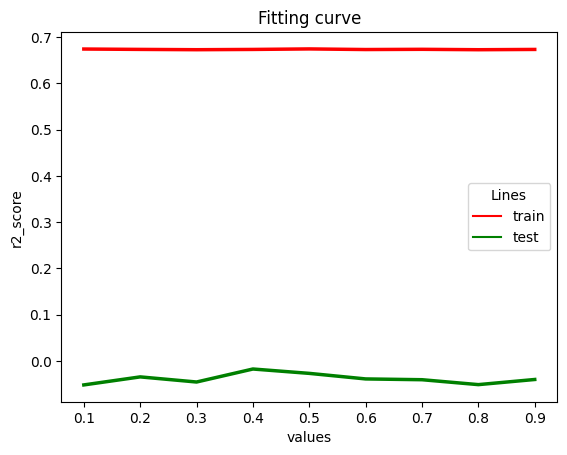

In [ ]:
fit_curve_plot(EnsembleTreeRegressor, 'samples_frac', np.arange(0.1, 1, 0.1), r2_score, X_train, X_test, y_train, y_test) 